In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
## Allow duplicates
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures

PATH = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join (PATH,"images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [19]:
### This is supposed to demo the Vanishing/Exploding Gradients (under or over firing)
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


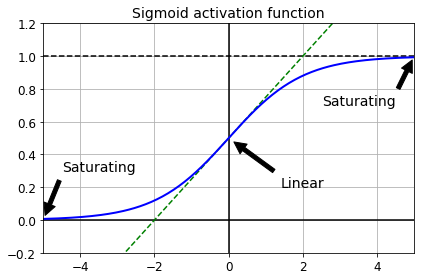

In [20]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

In [3]:
###  Test out He initialization
import tensorflow as tf

In [6]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [15]:
## tf_layers.dense normally uses Xavier initialization but you can override that to use He.

he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

ValueError: Variable hidden1/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "<ipython-input-8-5885a7e769e1>", line 5, in <module>
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
  File "/Users/udoucal/anaconda3/envs/tf/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/Users/udoucal/anaconda3/envs/tf/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):


In [24]:
## Note we have no idea how useful that would be....


In [16]:
## Try out "leaky RelU" which allows for some but not as "much" for values below 0.
## Hyperparameter "alpha" controls the level of leak (default of .01, but some research thinks .02 is better)
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


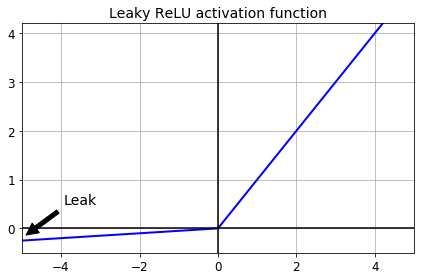

In [26]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [7]:
## Leaky ReLU in Tensor Flow
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [8]:
## Note activation parameter
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


In [29]:
## Training a NN on MNIST using ReLU (2 inner layers)
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [30]:
## Create placeholders
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [31]:
## Scope into "dnn"
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [32]:
## Name the "loss"
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [33]:
## Specify Learning Rate and Optimizer of Gradient Descent
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)


In [34]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [35]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [9]:
## Now that we have a model defined we can load the data  (note loading from keras not tf examples)

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]


In [10]:
## Define a function to batch load the data with parameters of epochs and batch size
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [38]:
## Run the data in the graph
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.86 Validation accuracy: 0.9044
5 Batch accuracy: 0.94 Validation accuracy: 0.9494
10 Batch accuracy: 0.92 Validation accuracy: 0.9658
15 Batch accuracy: 0.94 Validation accuracy: 0.971
20 Batch accuracy: 1.0 Validation accuracy: 0.9762
25 Batch accuracy: 1.0 Validation accuracy: 0.9774
30 Batch accuracy: 0.98 Validation accuracy: 0.9778
35 Batch accuracy: 1.0 Validation accuracy: 0.9786


In [39]:
## Now try ELU
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


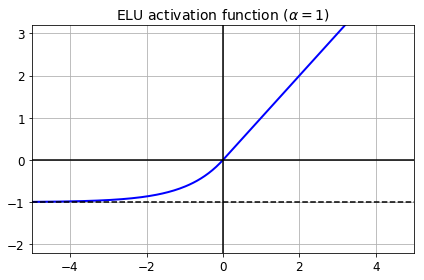

In [40]:
## Visualize ELU
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

In [41]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [42]:
## Test the whole thing with ELU

## Scope into "dnn2"
with tf.name_scope("dnn2"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.elu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [43]:
#Run again... 
## Run the data in the graph
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model2_final.ckpt")

ValueError: Cannot use the default session to execute operation: the operation's graph is different from the session's graph. Pass an explicit session to run(session=sess).

In [ ]:
## On to SELU
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [ ]:
## Note:  we found this did not work so we used "activation=tf.nn.selu"  in the actual layers

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
     return scale * elu(z, alpha)

In [ ]:
## This is only needed for above
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

In [ ]:
## Test SELU on random dataset - using created not tf selu
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

In [ ]:
## Create a graph with SELU
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_hidden3 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

## Test the whole thing with ELU

## Scope into "dnn2"
with tf.name_scope("dnn2"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.selu, name="hidden2")
    hidden3 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.selu, name="hidden3")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.05

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

In [ ]:
means = X_train.mean(axis=0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True) + 1e-10
X_val_scaled = (X_valid - means) / stds

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_val_scaled, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final_selu.ckpt")

In [ ]:
#Batch Normalization
##Also note that in order to run batch norm just before each hidden layer's activation function, 
## we apply the ELU activation function manually, right after the batch norm layer.

## Also activation is not specified because we apply sctivation after each batch normalization

reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

In [ ]:
#Reset the graph to try less repetive approach
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

In [ ]:
## Try using the "partial" function
from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)


In [ ]:
## Now build neural net with ELU and Batch Normalization
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()


In [ ]:
## Set up batching
n_epochs = 20
batch_size = 200

In [ ]:
## Set up logging

from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
accuracy_summary = tf.summary.scalar('accuracy', accuracy)
loss_summary = tf.summary.scalar('log_loss', loss)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [ ]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        accuracy_val, loss_val, accuracy_summary_str, loss_summary_str = sess.run([accuracy, loss, accuracy_summary, loss_summary], feed_dict={X: X_valid, y: y_valid})
        file_writer.add_summary(accuracy_summary_str, epoch)
        file_writer.add_summary(loss_summary_str, epoch)
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

In [ ]:
file_writer.close()

In [ ]:
##  Attempts at TF Records
## tf.data.Dataset.from_tensor_slices(X)

In [ ]:
## DNNData = tf.data.Dataset.from_tensor_slices(X)

In [ ]:
## from sklearn.preprocessing import StandardScaler
## scaler = StandardScaler()
## DNNDataScaled = scaler.fit_transform(X_train)

In [ ]:
## DNNDataScaled

In [ ]:
# ## Try the Widget Tool
# from witwidget.notebook.visualization import WitConfigBuilder
# from witwidget.notebook.visualization import WitWidget
# config_builder = WitConfigBuilder(examples).set_estimator_and_feature_spec(classifier, feature_spec)
# examples = df_to_examples(X_Train)


# def df_to_examples(df, columns=None):
#     examples = []
#     if columns == None:
#         columns = df.columns.values.tolist()
#     for index, row in df.iterrows():
#         example = tf.train.Example()
#         for col in columns:
#             if df[col].dtype is np.dtype(np.int64):
#                 example.features.feature[col].int64_list.value.append(int(row[col]))
#             elif df[col].dtype is np.dtype(np.float64):
#                 example.features.feature[col].float_list.value.append(row[col])
#             elif row[col] == row[col]:
#                 example.features.feature[col].bytes_list.value.append(row[col].encode('utf-8'))
#         examples.append(example)
#     return examples

# examples = df_to_examples(X_Train)
# WitWidget(config_builder)
# ## Total Failure

In [ ]:
### Gradient Clippsing with 5 layers

reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [ ]:
## learning_rate = 0.01
learning_rate = 0.05

In [ ]:
threshold = 1.0
## threshold = .5
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

In [ ]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [ ]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
n_epochs = 20
batch_size = 200

In [ ]:
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [ ]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")        


In [ ]:
## Find the trainable variables
[v.name for v in tf.trainable_variables()]

In [ ]:
[v.name for v in tf.global_variables()]

In [ ]:
## Reusing a TensorFlow Model
## Step #1 find the graphs structure
reset_graph()


In [ ]:
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

In [ ]:
## Find all the operations you need for training (you may not know the model's structure)
for op in tf.get_default_graph().get_operations():
    print(op.name)

In [ ]:
## Examples don't work for visualization in Juypter so used the Tensor board

In [ ]:
## Get the operations by name
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

In [ ]:
## If you are going to document your model maybe share important operations
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

In [ ]:
## Then people can get all they need by running this command
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

In [ ]:
## restoring a model to a session
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    # continue training the model...

In [ ]:
## Run the model and save a new check point 
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

In [ ]:
## Try just using the lower layers and then add new layers
reset_graph()

n_hidden4 = 20  # new layer
n_outputs = 10  # new layer

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden3/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [ ]:
## Try training this new model with different layers
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = new_saver.save(sess, "./my_new_model_final.ckpt")

In [ ]:
## Or if some reason someone has shared the Python code then you can just edit it.
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)


In [ ]:
## Always create a "saver" so not an overwrite
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):                                            # not shown in the book
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})        # not shown
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})     # not shown
        print(epoch, "Validation accuracy:", accuracy_val)                   # not shown

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

In [ ]:
## Reusing Models from other frameworks
reset_graph()

n_inputs = 2
n_hidden1 = 3

In [ ]:
## This is "tedious" as need to assign each item in the graph
## Output is the evaluations from the hidden layer
original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the assignment nodes for the hidden1 variables
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))  # not shown in the book

In [ ]:
## Or create new dedicated placeholders and "assignment nodes"
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the variables of layer hidden1
with tf.variable_scope("", default_name="", reuse=True):  # root scope
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")

# Create dedicated placeholders and assignment nodes
original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

In [ ]:
## Ways of getting the variables

In [ ]:
## Get collection
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")

In [ ]:
## Get Tensor by name
tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")

In [ ]:
tf.get_default_graph().get_tensor_by_name("hidden1/bias:0")

In [ ]:
## Ensuring the lower layers are "frozen"  - create the graph but don't use all layers in session
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [ ]:
## Reference only the "trainable" new layers in the session
with tf.name_scope("train"):                                         # not shown in the book
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)     # not shown
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)

In [ ]:
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [ ]:
## reference which are for re-use and which are for new training
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

In [ ]:
## or add "stop_gradient" so that any layer below that will be "frozen"
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [ ]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

In [ ]:
## Document parameters
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [ ]:
## Then train it
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

In [ ]:
## Cache the layers
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen & cached
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [ ]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
import numpy as np

n_batches = len(X_train) // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    h2_cache = sess.run(hidden2, feed_dict={X: X_train})
    h2_cache_valid = sess.run(hidden2, feed_dict={X: X_valid}) # not shown in the book

    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(X_train))
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(y_train[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})

        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_valid, # not shown
                                                y: y_valid})             # not shown
        print(epoch, "Validation accuracy:", accuracy_val)               # not shown

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

In [ ]:
## Start here with "Faster Optimizers"

In [ ]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

In [ ]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

In [ ]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9, use_nesterov=True)

In [ ]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                      momentum=0.9, decay=0.9, epsilon=1e-10)

In [ ]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [ ]:
## Learning Rate Scheduling
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [ ]:
## Specific rates 
with tf.name_scope("train"):       # not shown in the book
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

In [ ]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
## Run
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

In [ ]:
## Addressing Overfitting through regularization
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")


In [ ]:
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001 # l1 regularization hyperparameter

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")

In [ ]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

In [ ]:
## Passing regularization to tf.layers.dense and playing around with partial to leverage arguments
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [ ]:
## create scale parameter for kernel regularizer
scale = 0.001

In [ ]:
## Try using the "partial" function
from functools import partial
my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")

In [ ]:
## add regularization losses to base loss
with tf.name_scope("loss"):                                     # not shown in the book
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(  # not shown
        labels=y, logits=logits)                                # not shown
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   # not shown
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

In [ ]:
## standard set-up
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
## Run it
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

In [ ]:
### or use Max_Norm_regularizer..
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm

In [ ]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [ ]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [ ]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
## Training includes clipping operations with each session

n_epochs = 20
batch_size = 50

clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) # not shown
        print(epoch, "Validation accuracy:", acc_valid)               # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")             # not shown

In [ ]:
## Exercise - build a deep learning model with 5 hidden layers of 100 neurons each.  
## Use He Initialization and ELU Activation.

In [ ]:
# reset_graph()

# n_inputs = 28 * 28  # MNIST
# n_hidden1 = 100
# n_hidden2 = 100
# n_hidden3 = 100
# n_hidden4 = 100
# n_hidden4 =100
# n_outputs = 10

In [ ]:
# X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
# y = tf.placeholder(tf.int32, shape=(None), name="y")
# he_init = tf.variance_scaling_initializer()

# with tf.name_scope("dnn"):
#     hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, kernel_initializer=he_init, name="hidden1")
#     hidden2 = tf.layers.dense(X, n_hidden2, activation=tf.nn.elu, kernel_initializer=he_init, name="hidden2")
#     hidden3 = tf.layers.dense(X, n_hidden3, activation=tf.nn.elu, kernel_initializer=he_init, name="hidden3")
#     hidden4 = tf.layers.dense(X, n_hidden4, activation=tf.nn.elu, kernel_initializer=he_init, name="hidden4")
#     hidden5 = tf.layers.dense(X, n_hidden5, activation=tf.nn.elu, kernel_initializer=he_init, name="hidden5")
#     logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

In [ ]:
# with tf.name_scope("eval"):
#     correct = tf.nn.in_top_k(logits, y, 1)
#     accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

# learning_rate = 0.05

# init = tf.global_variables_initializer()
# saver = tf.train.Saver()

In [ ]:
# optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [ ]:
# ## Now that we have a model defined we can load the data  (note loading from keras not tf examples)

# (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
# X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
# X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
# y_train = y_train.astype(np.int32)
# y_test = y_test.astype(np.int32)
# X_valid, X_train = X_train[:5000], X_train[5000:]
# y_valid, y_train = y_train[:5000], y_train[5000:]

In [ ]:
## Shorter syntax than mine
he_init = tf.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer,
                                     name="hidden%d" % (layer + 1))
        return inputs

In [ ]:
n_inputs = 28 * 28 # MNIST
n_outputs = 5

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

In [ ]:
## Exercise: Using Adam optimization and early stopping, try training it on MNIST but only on digits 0 to 4, 
## as we will use transfer learning for digits 5 to 9 in the next exercise.


In [ ]:
learning_rate = 0.05

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [53]:
## Digits < 5
X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
X_test1 = X_test[y_test < 5]
y_test1 = y_test[y_test < 5]

In [ ]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./my_mnist_model_0_to_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

In [14]:
## Fancy Pants with all the hyperparameters
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """Initialize the DNNClassifier by simply storing all the hyperparameters."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """Build the hidden layers, with support for batch normalization and dropout."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """Build the same model as earlier"""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # Make the important operations available easily through instance variables
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping."""
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # Translate the labels vector to a vector of sorted class indices, containing
        # integers from 0 to n_outputs - 1.
        # For example, if y is equal to [8, 8, 9, 5, 7, 6, 6, 6], then the sorted class
        # labels (self.classes_) will be equal to [5, 6, 7, 8, 9], and the labels vector
        # will be translated to [3, 3, 4, 0, 2, 1, 1, 1]
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # extra ops for batch normalization
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # needed in case of early stopping
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # Now train the model!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # If we used early stopping then rollback to the best model found
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

NameError: name 'he_init' is not defined

In [ ]:
## Compare to out of the box DNN Classifier
dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

In [52]:
## Use randomized search for best parameters
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                cv=3, random_state=42, verbose=2)
rnd_search.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

# If you have Scikit-Learn 0.18 or earlier, you should upgrade, or use the fit_params argument:
# fit_params = dict(X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)
# rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
#                                 fit_params=fit_params, random_state=42, verbose=2)
# rnd_search.fit(X_train1, y_train1)

NameError: name 'X_train1' is not defined

In [ ]:
## find the best parameters
rnd_search.best_params_

In [ ]:
##  Did we get better?
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

In [ ]:
##Save the model
rnd_search.best_estimator_.save("./my_best_mnist_model_0_to_4")

In [ ]:
## Adding Batch Normalization
dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=140, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

In [ ]:
## Check the accuracy score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

In [13]:
## Same model with batch normalization
dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=90, random_state=42,
                           batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

NameError: name 'DNNClassifier' is not defined

In [ ]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

In [49]:
## Try for other parameters...

from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "batch_norm_momentum": [0.9, 0.95, 0.98, 0.99, 0.999],
}

rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50, cv=3,
                                   random_state=42, verbose=2)
rnd_search_bn.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

# If you have Scikit-Learn 0.18 or earlier, you should upgrade, or use the fit_params argument:
# fit_params = dict(X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)
# rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
#                                    fit_params=fit_params, random_state=42, verbose=2)
# rnd_search_bn.fit(X_train1, y_train1)

TypeError: leaky_relu() got an unexpected keyword argument 'alpha'

In [ ]:
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

In [ ]:
## Save the model
rnd_search.best_estimator_.save("./my_best_mnist_model_0_to_4")

In [12]:
## Add Batch Normalization
dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=140, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

NameError: name 'DNNClassifier' is not defined

In [ ]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

In [17]:
## Find better parameters for Batch Normalization..
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "batch_norm_momentum": [0.9, 0.95, 0.98, 0.99, 0.999],
}

rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50, cv=3,
                                   random_state=42, verbose=2)
rnd_search_bn.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

# If you have Scikit-Learn 0.18 or earlier, you should upgrade, or use the fit_params argument:
# fit_params = dict(X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)
# rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
#                                    fit_params=fit_params, random_state=42, verbose=2)
# rnd_search_bn.fit(X_train1, y_train1)

TypeError: leaky_relu() missing 1 required positional argument: 'z'

In [1]:
from sklearn.model_selection import RandomizedSearchCV
rnd_search_bn.best_params_

NameError: name 'rnd_search_bn' is not defined